---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Network-constrained spatial autocorrelation
### Performing and visualizing exploratory spatial data analysis

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an advanced walk-through for:**

1. Demonstrating spatial autocorrelation with [pysal/esda](https://pysal.org/esda/)
2. Calculating [Moran's *I*](https://pysal.org/esda/generated/esda.Moran.html#esda.Moran) on a segmented network
3. Visualizing spatial autocorrelation with [pysal/splot](https://splot.readthedocs.io/en/latest/) for empirical and synthetic data

In [1]:
%load_ext watermark
%watermark

2020-10-22T17:26:07-04:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.1 
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
import esda
import libpysal
import matplotlib
#import matplotlib.pyplot as plt
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import spaghetti
import splot

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
libpysal            4.3.0
matplotlib_scalebar 0.6.2
numpy               1.19.1
spaghetti           1.5.1
matplotlib          3.3.2
splot               1.1.3
esda                2.3.1



In [3]:
import warnings
warnings.filterwarnings(
    "ignore", category=matplotlib.MatplotlibDeprecationWarning
)

In [4]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

----------------

### Instantiating a `spaghetti.Network` object and a point pattern
#### Instantiate the network from a `.shp` file

In [5]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
ntw

####  Extract network arcs as a `geopandas.GeoDataFrame`

In [6]:
_, arc_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
arc_df.head()

,id,geometry,comp_label
0,"(0, 1)","LINESTRING (728368.048 877125.895, 728368.139 ...",0
1,"(0, 2)","LINESTRING (728368.048 877125.895, 728367.458 ...",0
2,"(1, 110)","LINESTRING (728368.139 877023.272, 728612.255 ...",0
3,"(1, 127)","LINESTRING (728368.139 877023.272, 727708.140 ...",0
4,"(1, 213)","LINESTRING (728368.139 877023.272, 728368.729 ...",0


#### Associate the network with a point pattern

In [7]:
pp_name = "crimes"
pp_shp = libpysal.examples.get_path("%s.shp" % pp_name)
ntw.snapobservations(pp_shp, pp_name, attribute=True)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x7f91f89e4fd0>}

####  Extract the crimes point pattern as a `geopandas.GeoDataFrame`

In [8]:
pp_df = spaghetti.element_as_gdf(ntw, pp_name=pp_name)
pp_df.head()

,id,geometry,comp_label
0,0,POINT (727913.000 875721.000),0
1,1,POINT (724812.000 875763.000),0
2,2,POINT (727391.000 875853.000),0
3,3,POINT (728017.000 875858.000),0
4,4,POINT (727525.000 875860.000),0


--------------------------

### 1. ESDA — Exploratory Spatial Data Analysis with [pysal/esda](https://esda.readthedocs.io/en/latest/)

**The Moran's *I* test statistic allows for the inference of how clustered (or dispersed) a dataset is while considering both attribute values and spatial relationships. A value of closer to +1 indicates absolute clustering while a value of closer to -1 indicates absolute dispersion. Complete spatial randomness takes the value of 0. See the** [esda documentation](https://pysal.org/esda/) **for in-depth descriptions and tutorials.**

In [9]:
def calc_moran(net, name, w):
    """Calculate a Moran's I statistic based on network arcs."""
    # Compute the counts
    pointpat = net.pointpatterns[name]
    counts = net.count_per_link(pointpat.obs_to_arc, graph=False)
    # Build the y vector
    arcs = w.neighbors.keys()
    y = [counts[a] if a in counts.keys() else 0. for i, a in enumerate(arcs)]
    # Moran's I
    moran = esda.moran.Moran(y, w, permutations=9999)
    return moran, y

#### Moran's *I* using the network representation's *W*

In [10]:
moran_ntwwn, yaxis_ntwwn = calc_moran(ntw, pp_name, ntw.w_network)
moran_ntwwn.I

0.005192687496078421

#### Moran's *I* using the graph representation's *W*

In [11]:
moran_ntwwg, yaxis_ntwwg = calc_moran(ntw, pp_name, ntw.w_graph)
moran_ntwwg.I

0.05223210335368553

**Interpretation:**

* **Although both the network and graph representations (**``moran_ntwwn`` **and** ``moran_ntwwg``**, respectively) display minimal postive spatial autocorrelation, a slighly higher value is observed in the graph represention. This is likely due to more direct connectivity in the graph representation; a direct result of eliminating** [degree-2 vertices](https://en.wikipedia.org/wiki/Degree_(graph_theory))**. The Moran's *I* for both the network and graph representations suggest that network arcs/graph edges attributed with associated crime counts are nearly randomly distributed.**

--------------------------------

### 2. Moran's *I* on a segmented network
#### Moran's *I* on a network split into 200-foot segments

In [12]:
n200 = ntw.split_arcs(200.0)
n200

In [13]:
moran_n200, yaxis_n200 = calc_moran(n200, pp_name, n200.w_network)
moran_n200.I

0.008782712541437603

#### Moran's *I* on a network split into 50-foot segments

In [14]:
n50 = ntw.split_arcs(50.0)
n50

In [15]:
moran_n50, yaxis_n50 = calc_moran(n50, pp_name, n50.w_network)
moran_n50.I

0.005151667718437952

**Interpretation:**

* **Contrary to above, both the 200-foot and 50-foot segmented networks (**``moran_n200`` **and** ``moran_n50``**, respectively) display minimal negative spatial autocorrelation, with slighly lower values being observed in the 200-foot representation. However, similar to above the Moran's *I* for both the these representations suggest that network arcs attributed with associated crime counts are nearly randomly distributed.**

---------------------------

### 3. Visualizing ESDA with `splot`

**Here we are demonstrating** [spatial lag](https://pysal.org/esda/notebooks/spatialautocorrelation.html#Attribute-Similarity)**, which refers to attribute similarity. See the** [splot documentation](https://splot.readthedocs.io/en/latest/) **for in-depth descriptions and tutorials. In this first section empirical data is utilized followed by a highly-clusterd synthetic example.**

In [16]:
from splot.esda import moran_scatterplot, lisa_cluster, plot_moran

#### Moran scatterplot

**Plotted with equal aspect**

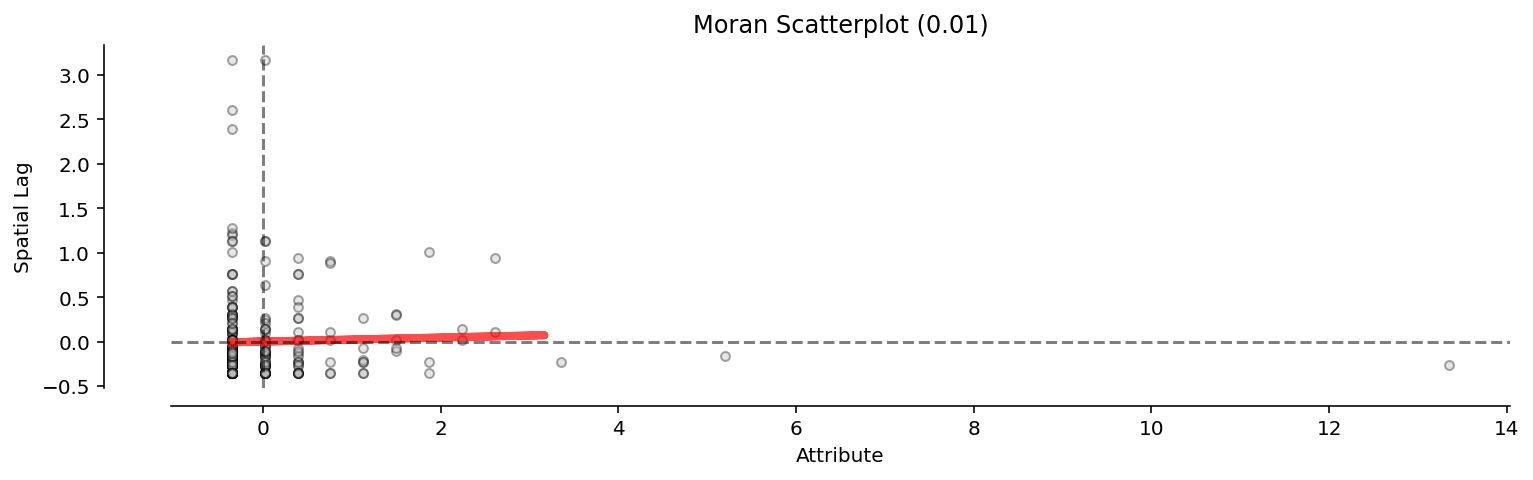

In [17]:
figsize = (12,6)
fig, ax = matplotlib.pyplot.subplots(figsize=figsize)
fitline_kwds = {"color":"r", "lw": 4, "alpha":.7}
scatter_kwds = {"s":20, "edgecolors":"k", "alpha":.35}
pltkwds = {"fitline_kwds": fitline_kwds, "scatter_kwds": scatter_kwds}
moran_scatterplot(moran_ntwwn, aspect_equal=True, ax=ax, **pltkwds);

**Plotted without equal aspect**

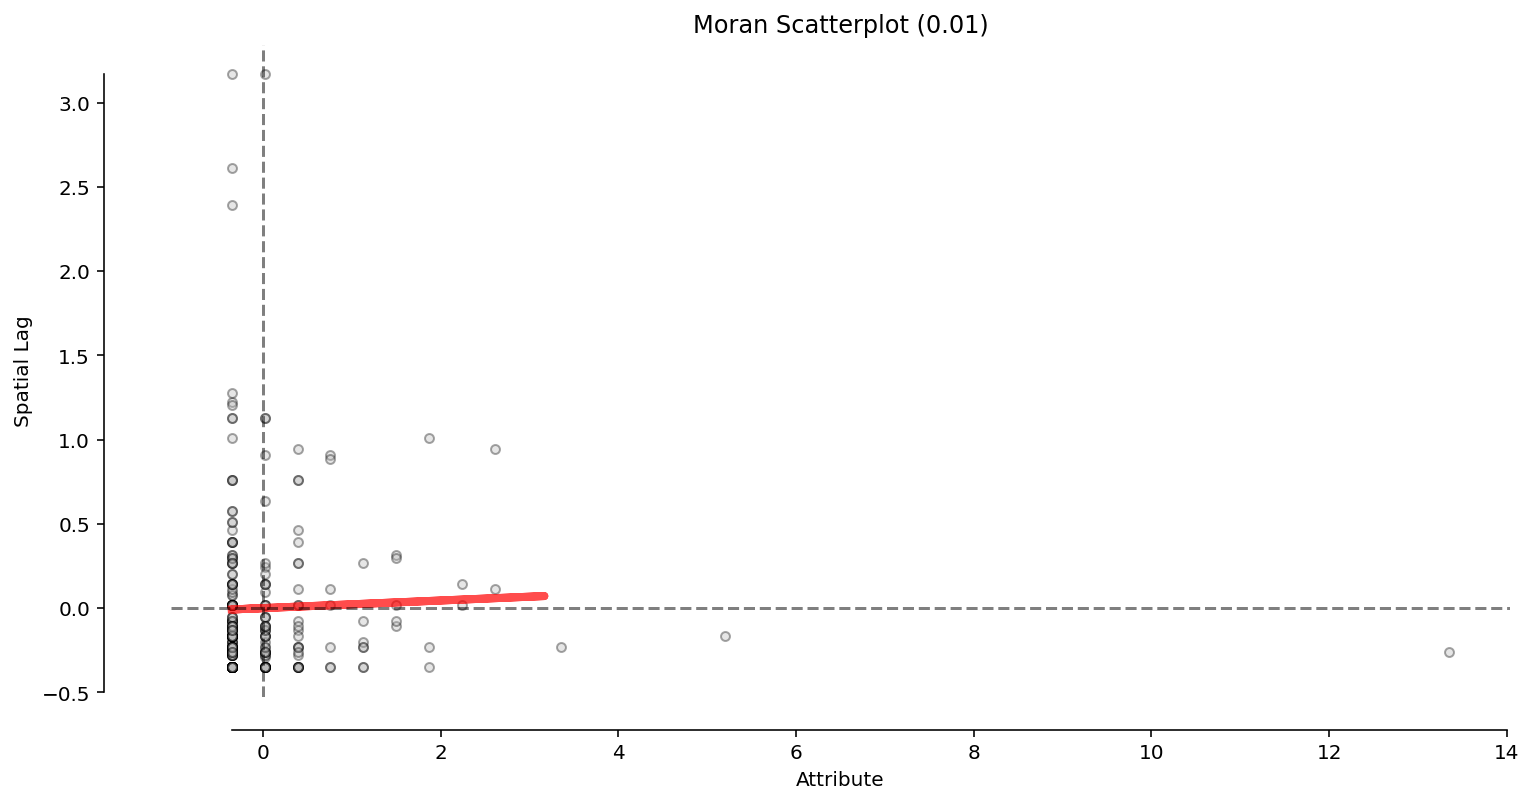

In [18]:
fig, ax = matplotlib.pyplot.subplots(figsize=figsize)
moran_scatterplot(moran_ntwwn, aspect_equal=False, ax=ax, **pltkwds);

**This scatterplot demostrates the attribute values and associated attribute similarities in space (spatial lag) for the network representation's *W* (**``moran_ntwwn``**).**

#### Reference distribution and Moran scatterplot

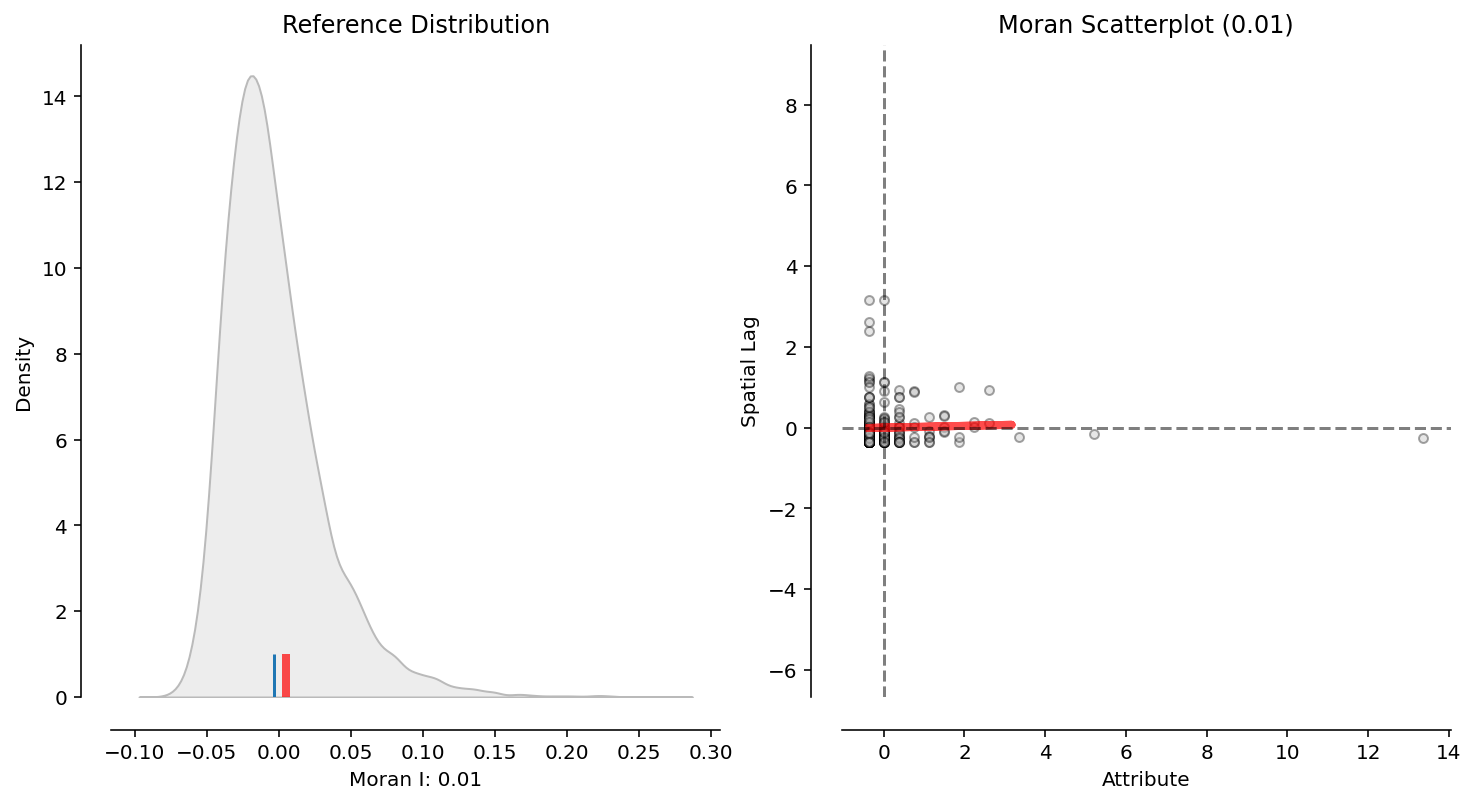

In [19]:
plot_moran(moran_ntwwn, zstandard=True, figsize=figsize, **pltkwds);

**This figure incorporates the reference distribution of Moran's *I* values into the above scatterplot of the network representation's *W* (**``moran_ntwwn``**).**

#### Local Moran's *l*

**The demonstrations above considered the dataset as a whole, providing a global measure. The following demostrates the consideration of** [local spatial autocorrelation](https://pysal.org/esda/notebooks/spatialautocorrelation.html#Local-Autocorrelation:-Hot-Spots,-Cold-Spots,-and-Spatial-Outliers)**, providing a measure for each observation. This is best interpreted visually, here with another scatterplot colored to indicate** [relationship type](https://nbviewer.jupyter.org/github/pysal/splot/blob/master/notebooks/esda_morans_viz.ipynb#Visualizing-Local-Autocorrelation-with-splot---Hot-Spots,-Cold-Spots-and-Spatial-Outliers)**.**

**Plotted with equal aspect**

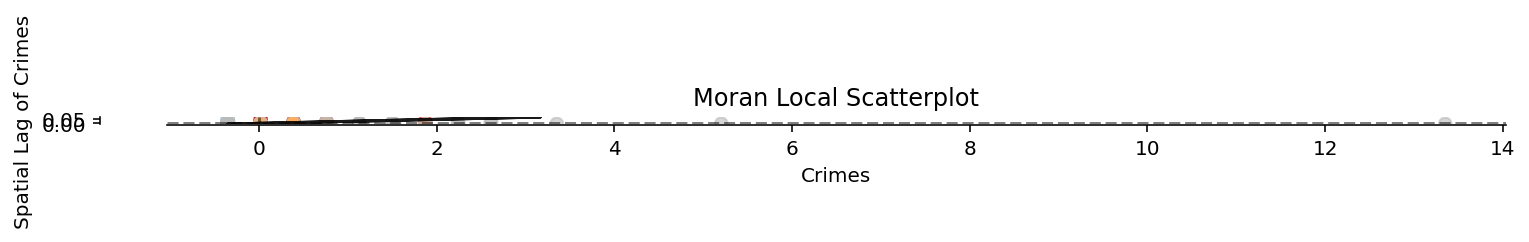

In [20]:
p = 0.05
moran_loc_ntwwn = esda.moran.Moran_Local(yaxis_ntwwn, ntw.w_network)
fig, ax = matplotlib.pyplot.subplots(figsize=figsize)
moran_scatterplot(moran_loc_ntwwn, p=p, aspect_equal=True, ax=ax)
ax.set(xlabel="Crimes", ylabel="Spatial Lag of Crimes");

**Plotted without equal aspect**

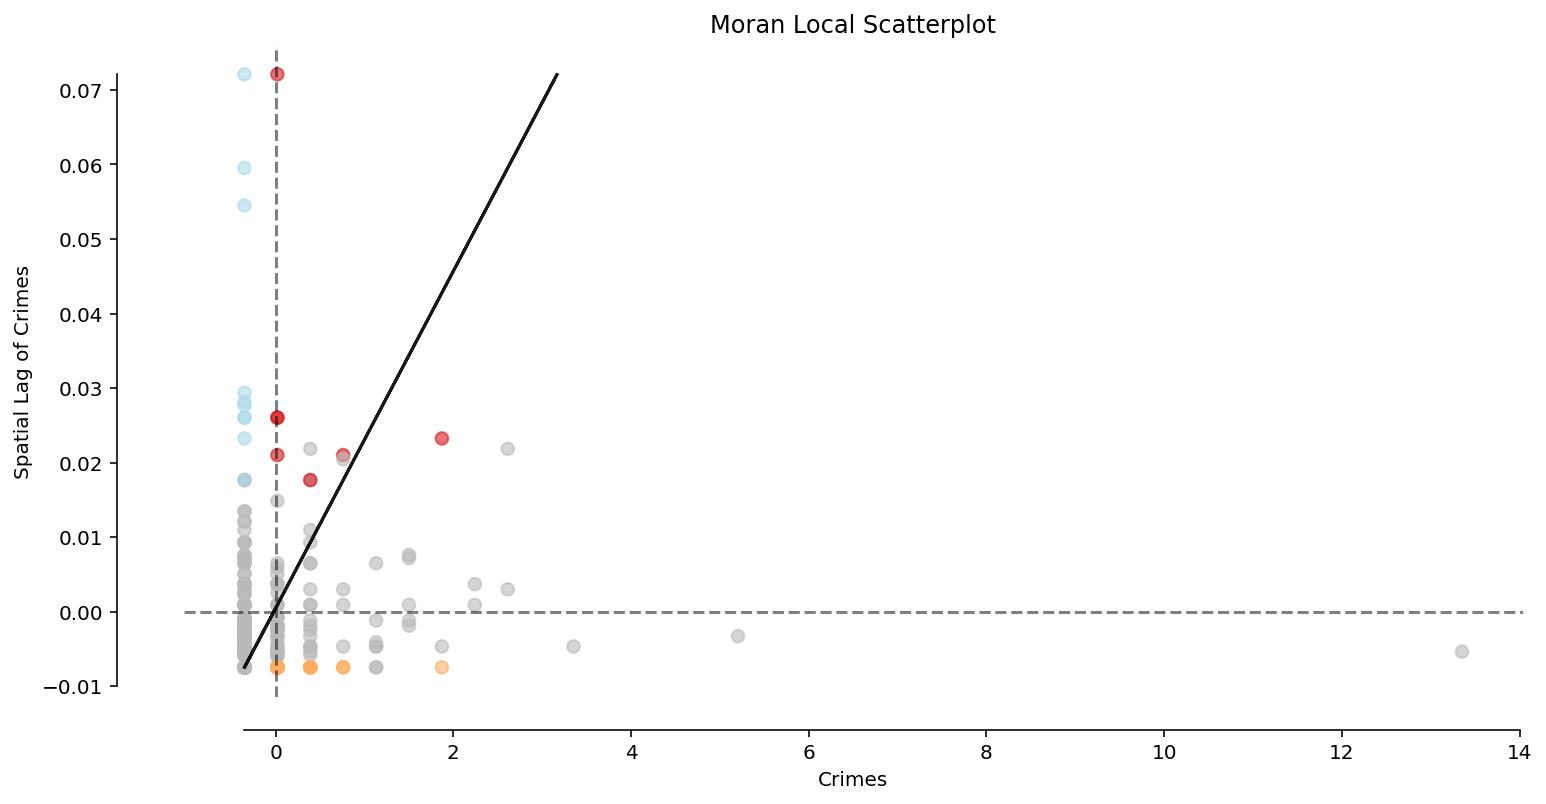

In [21]:
fig, ax = matplotlib.pyplot.subplots(figsize=figsize)
moran_scatterplot(moran_loc_ntwwn, p=p, aspect_equal=False, ax=ax)
ax.set(xlabel="Crimes", ylabel="Spatial Lag of Crimes");

**Interpretation:**

* **The majority of observations (network arcs) display no significant local spatial autocorrelation (shown in gray).**

#### Plotting Local Indicators of Spatial Autocorrelation ([LISA](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1538-4632.1995.tb00338.x)) 

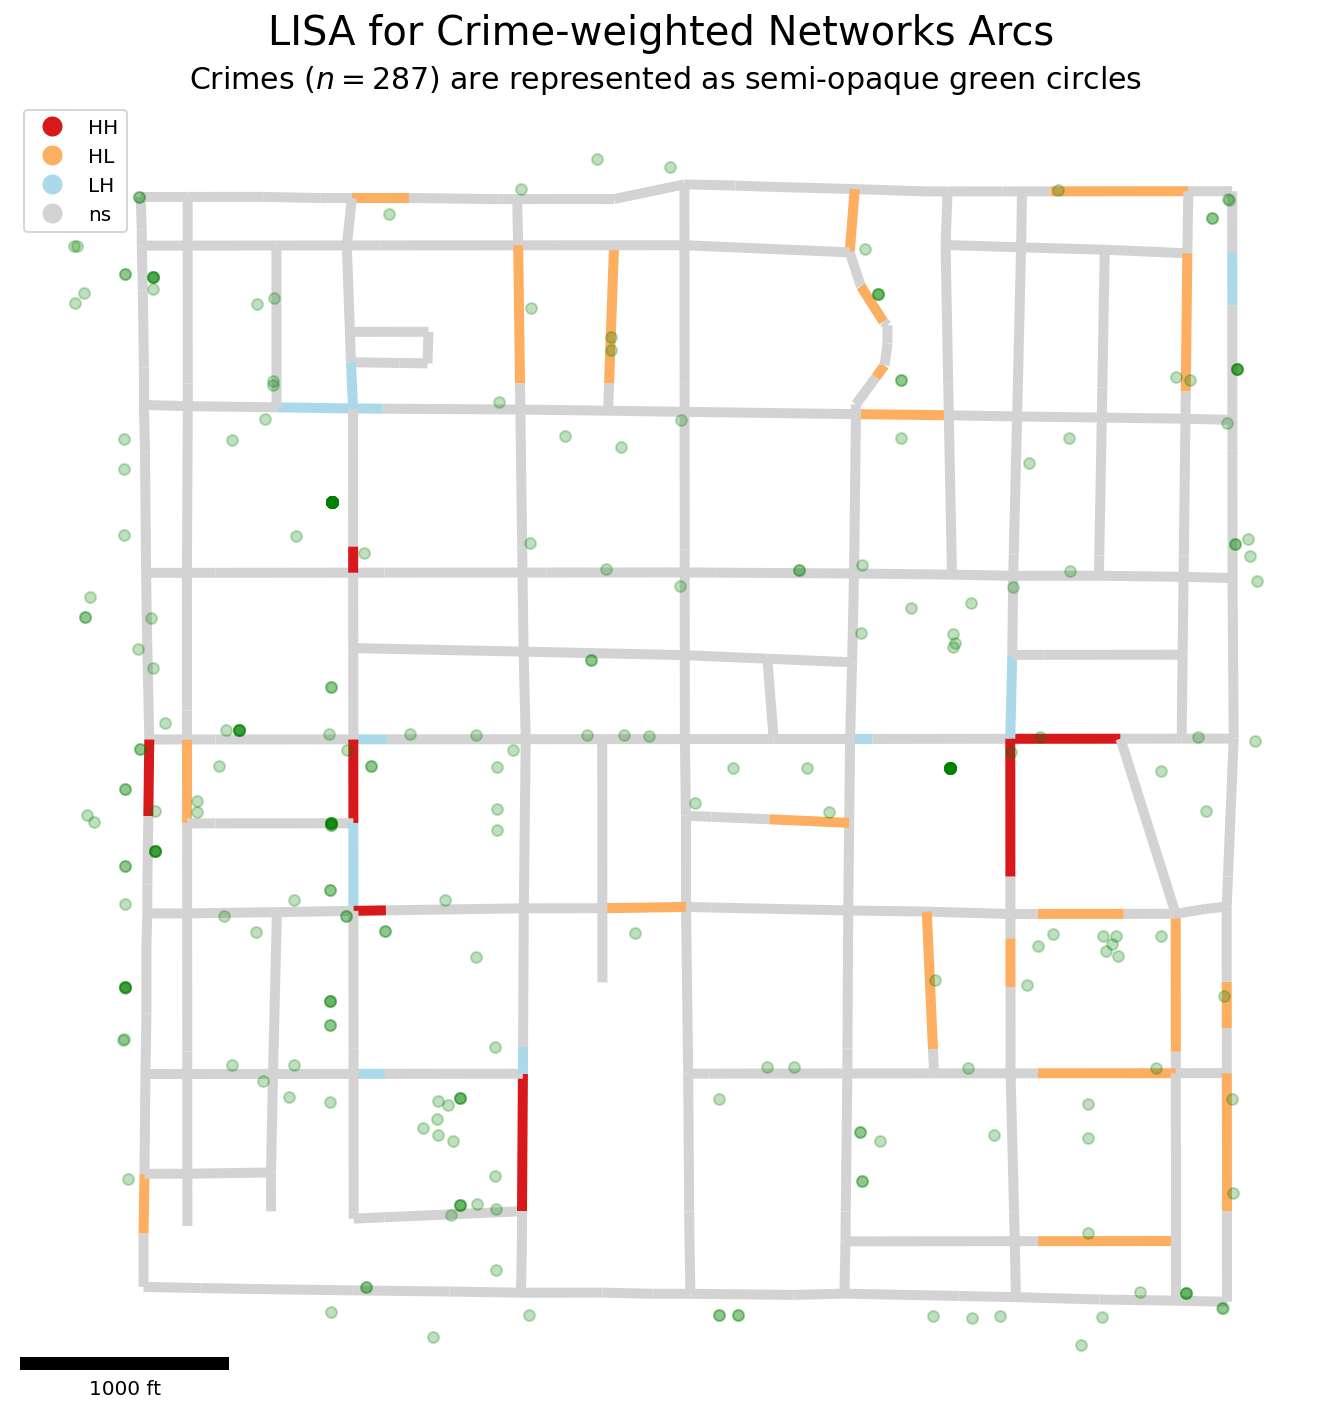

In [22]:
lisa_args = moran_loc_ntwwn, arc_df
lisa_kwds = {"p":p, "figsize":(12,12), "lw":5, "zorder":0}
f, ax = lisa_cluster(*lisa_args, **lisa_kwds)
pp_df.plot(ax=ax, alpha=.25, color="g", markersize=30, zorder=1)
suptitle = "LISA for Crime-weighted Networks Arcs"
matplotlib.pyplot.suptitle(suptitle, fontsize=20, x=.51, y=.93)
subtitle = "Crimes ($n=%s$) are represented as semi-opaque green circles"
matplotlib.pyplot.title(subtitle % pp_df.shape[0], fontsize=15)
sbkw = {"units":"ft", "dimension":"imperial-length", "fixed_value":1000}
sbkw.update({"location":"lower left", "box_alpha":.75})
ax.add_artist(matplotlib_scalebar.scalebar.ScaleBar(1, **sbkw));

------------------------------
#### A highly-clustered synthetic example

In [23]:
ncrimes, cluster_crimes = 30, []; numpy.random.seed(0)
minx, miny, maxx, maxy = [725400, 877400, 727100, 879100]
for c in range(ncrimes):
    for plus_minus in [1000, -2000]:
        x = numpy.random.uniform(minx+plus_minus, maxx+plus_minus)
        y = numpy.random.uniform(miny+plus_minus, maxy+plus_minus)
        cluster_crimes.append(libpysal.cg.Point((x,y)))

In [24]:
ntw.snapobservations(cluster_crimes, pp_name, attribute=True)
moran_ntwwn, yaxis_ntwwn = calc_moran(ntw, pp_name, ntw.w_network)
moran_loc_ntwwn = esda.moran.Moran_Local(yaxis_ntwwn, ntw.w_network)
pp_df = spaghetti.element_as_gdf(ntw, pp_name=pp_name)

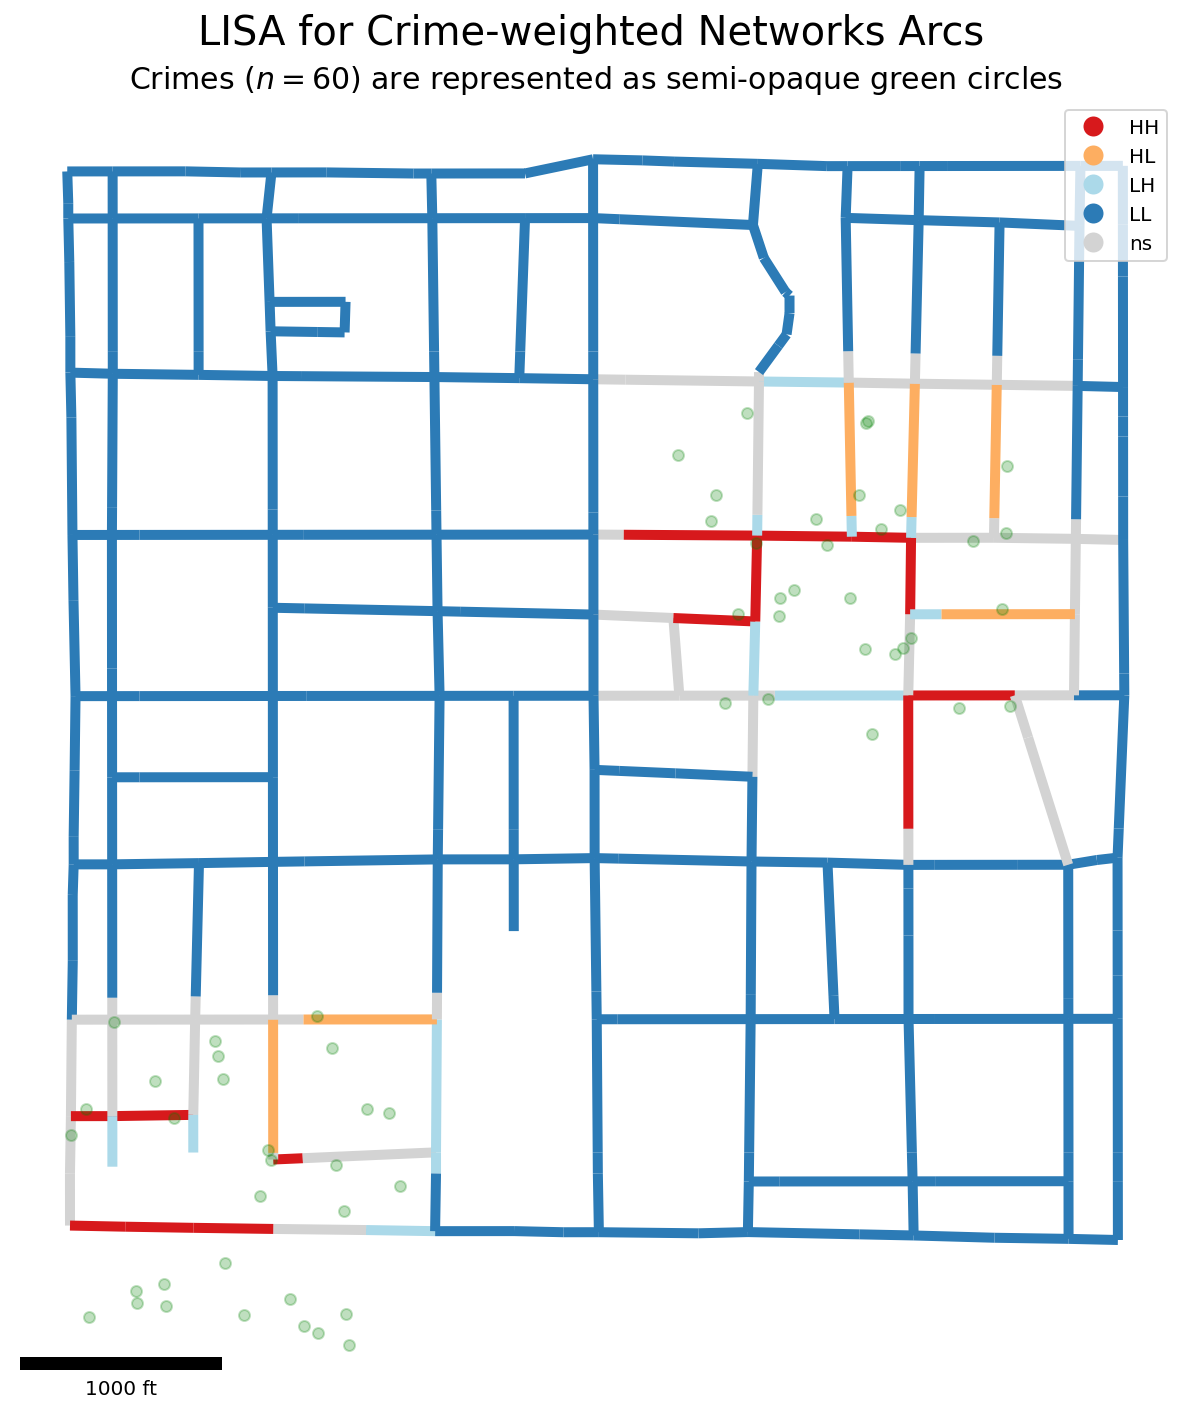

In [25]:
lisa_args = moran_loc_ntwwn, arc_df
f, ax = lisa_cluster(*lisa_args, **lisa_kwds)
pp_df.plot(ax=ax, zorder=1, alpha=.25, color="g", markersize=30)
matplotlib.pyplot.suptitle(suptitle, fontsize=20, x=.51, y=.93)
matplotlib.pyplot.title(subtitle % pp_df.shape[0], fontsize=15)
ax.add_artist(matplotlib_scalebar.scalebar.ScaleBar(1, **sbkw));

-----------------